In [4]:
import sys
sys.path.append('..')
from tsai.utils import *
from tsai.basics import *
from swdf.utils import download_dst_data
from matplotlib import dates as mdates
import sklearn
my_setup(sklearn)
from swdf.preprocessing import BackForwardFillMissing


os              : Linux-6.8.0-39-generic-x86_64-with-glibc2.31
python          : 3.10.12
tsai            : 0.3.10
fastai          : 2.7.15
fastcore        : 1.5.49
sklearn         : 1.5.1
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 3070 Ti Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.28 GB
GPU memory      : [8.0] GB


# DST Geomagnetix Index Data Preprocessing

In [5]:
config_geo = yaml2dict('./config/geodst.yaml', attrdict=True)
config_geo = config_geo.data
config = AttrDict(config_geo)
config

```json
{'data_path': '../data/DST_IAGA2002.txt', 'force_download': False}
```

In [6]:
fname = config.data_path if not config.force_download \
    else download_dst_data(save_folder=config.data_path)
fname

'../data/DST_IAGA2002.txt'

In [7]:
from io import StringIO

def filter_lines(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    filtered_lines = [line for line in lines if not line.strip().endswith('|')]
    return ''.join(filtered_lines)

filtered_data = filter_lines(fname) 

In [8]:
# Use StringIO to simulate a file object
data_io = StringIO(filtered_data)

with open("../data/output_dst.txt", 'w') as file:
    file.write(filtered_data)

# Read the cleaned data into a DataFrame
df_dst_raw = pd.read_csv(data_io,
                 comment='#',  # Skip lines starting with '#'
                 delim_whitespace=True,  # Since your columns are separated by whitespace
                 names=['DATE', 'TIME', 'DOY', 'DST'],  # Assign column names manually
                 dtype={'DOY': int, 'DST': float},  # Specify data types for columns
                 na_values='99999.99'
            )

# Combine 'DATE' and 'TIME' into a single 'DateTime' column
df_dst_raw['Datetime'] = pd.to_datetime(df_dst_raw['DATE'] + ' ' + df_dst_raw['TIME'])

# Optionally, drop the original 'DATE' and 'TIME' columns if they are no longer needed
df_dst_raw.drop(columns=['DATE', 'DOY', 'TIME'], inplace=True)
df_dst_raw

,DST,Datetime
0,11.0,1957-01-01 00:00:00
1,13.0,1957-01-01 01:00:00
2,12.0,1957-01-01 02:00:00
3,12.0,1957-01-01 03:00:00
4,9.0,1957-01-01 04:00:00
...,...,...
594643,NaN,2024-08-31 19:00:00
594644,NaN,2024-08-31 20:00:00
594645,NaN,2024-08-31 21:00:00
594646,NaN,2024-08-31 22:00:00


In [9]:
# Check if there are any missing values
df_dst_raw.isna().sum()

DST         591
Datetime      0
dtype: int64

In [10]:
# Distinct value of the column DST (classification problem?)
df_dst_raw.DST.unique().__len__()

441

In [11]:
preproc_pipe = sklearn.pipeline.Pipeline([
    ('fill_missing', BackForwardFillMissing(['DST'])), # fill missing data (1st ffill. 2nd value=0)
    ('shrinker', TSShrinkDataFrame()), # shrik dataframe memory usage and set the right dtypes
], verbose=True)

df = preproc_pipe.fit_transform(df_dst_raw)
df

[Pipeline] ...... (step 1 of 2) Processing fill_missing, total=   0.0s
Initial memory usage: 13.60 MB  
Final memory usage  : 11.33 MB   (-16.7%)
[Pipeline] .......... (step 2 of 2) Processing shrinker, total=   0.0s


,DST,Datetime
0,11.0,1957-01-01 00:00:00
1,13.0,1957-01-01 01:00:00
2,12.0,1957-01-01 02:00:00
3,12.0,1957-01-01 03:00:00
4,9.0,1957-01-01 04:00:00
...,...,...
594052,-16.0,2024-08-07 04:00:00
594053,-15.0,2024-08-07 05:00:00
594054,-13.0,2024-08-07 06:00:00
594055,-8.0,2024-08-07 07:00:00


In [12]:
df.isna().sum()

DST         0
Datetime    0
dtype: int64

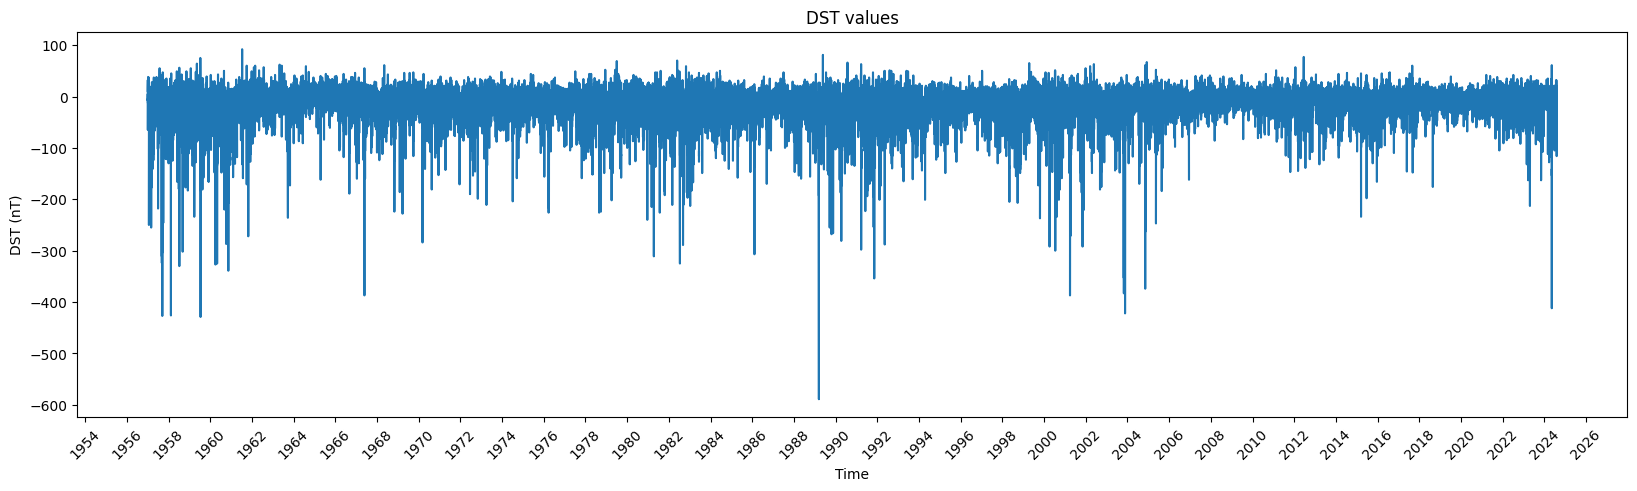

In [13]:
# hide

# Plot the DST values
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_dst_raw.Datetime, df_dst_raw.DST)
ax.set_title('DST values')
ax.set_xlabel('Time')
ax.set_ylabel('DST (nT)')

ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.show()

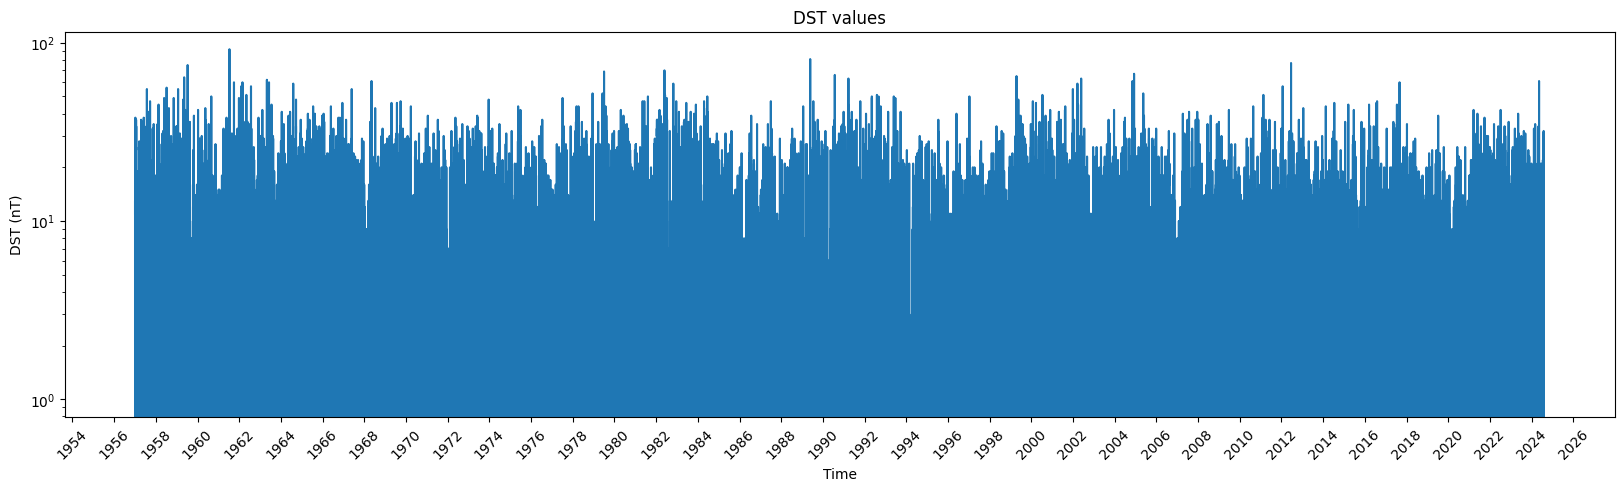

In [14]:
# hide

# Plot the DST values
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_dst_raw.Datetime, df_dst_raw.DST)
ax.set_title('DST values')
ax.set_xlabel('Time')
ax.set_ylabel('DST (nT)')
ax.set_yscale('log')

ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.show()


In [15]:
save_object(df, "./preprocessed_data/dataframes/geodst.pkl")
save_object(preproc_pipe, "./preprocessed_data/pipelines/preproc_geodst.pkl")

preprocessed_data/dataframes directory already exists.
DataFrame saved as preprocessed_data/dataframes/geodst.pkl
preprocessed_data/pipelines directory already exists.
Pipeline saved as preprocessed_data/pipelines/preproc_geodst.pkl
